In [41]:
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

In [42]:
def getBad(filename, Aq=1, Bq=2, As=2, Bs=3):
    jpub_count = pd.read_csv(filename, sep='\t',
                    usecols=['EditorId','IssnId','BeAvg','AfAvg','left','right','Year0'],
                    dtype={'EditorId':int,'IssnId':int,'BeAvg':float,'AfAvg':float,
                           'left':int,'right':int,'Year0':int})
    
    normal = jpub_count[jpub_count.apply(lambda row: row.AfAvg < max(row.BeAvg * Bq, Aq), axis=1)]
    Q = jpub_count[jpub_count.apply(lambda row: row.AfAvg >= max(row.BeAvg * Bq, Aq), axis=1)]
    S = jpub_count[jpub_count.apply(lambda row: row.AfAvg >= max(row.BeAvg * Bs, As), axis=1)]
    
    print(f'# Aq: {Aq}, Bq {Bq}, As: {As}, Bs: {Bs} | ',
          f'questionable: {round(Q.shape[0]/jpub_count.shape[0]*100, 2)}%,\
          suspicious: {round(S.shape[0]/jpub_count.shape[0]*100, 2)}%')
    
    return normal, Q, S

In [43]:
pubCountFile = '../data/figure_3/EditorJournalPub_5.csv'

n, q, s = getBad(pubCountFile)

n = n[['EditorId','IssnId','left','right','Year0']].drop_duplicates()
s = s[['EditorId','IssnId','left','right','Year0']].drop_duplicates()
q = q[['EditorId','IssnId','left','right','Year0']].drop_duplicates()

# Aq: 1, Bq 2, As: 2, Bs: 3 |  questionable: 8.27%,          suspicious: 1.81%


## Over time

In [44]:
def plotTemporal(df, outcome, ax, c, label):
    
    x = [a for a in range(1980, 2019)]
    y = [df[df.Year==d][outcome] for d in x]
    
    yerr=[scipy.stats.sem(a)*1.96 for a in y]
    ymean = [a.mean() for a in y]
    
    lo = [ymean[i] + yerr[i] for i in range(len(x))]
    hi = [ymean[i] - yerr[i] for i in range(len(x))]
    
    ax.plot(x, ymean, color=c, label=label)
    
    ax.fill_between(x, lo, hi, color=c, alpha=0.2)

In [45]:
pubCountFile = '../data/figure_3/EditorJournalPub_5.csv'

In [46]:
editors = pd.read_csv("../data/figure_3/AllEditors.csv", sep='\t',
                     usecols=["EditorId", "IssnId", "start_year", "end_year"],
                     dtype={"EditorId":int, "IssnId":int, "start_year":int, "end_year":int})
editors.shape

(12995, 4)

In [47]:
editors = editors.merge(q.assign(Q=1), how='left', on=['EditorId','IssnId'])
editors = editors.merge(s.assign(S=1), how='left', on=['EditorId','IssnId']).fillna(0)
editors.shape

(12995, 12)

In [48]:
temporal_trend = []
for year in range(editors.start_year.min(), editors.end_year.max()+1):
    temporal_trend.append(editors[(editors.start_year <= year) & (editors.end_year >= year)].assign(Year=year))

temporal_trend = pd.concat(temporal_trend, sort=False, ignore_index=True)

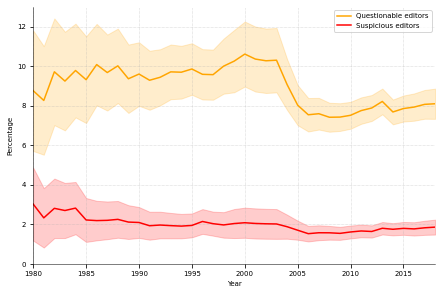

In [49]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 12*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()
plotTemporal(temporal_trend, 'Q', ax, 'orange', 'Questionable editors')
plotTemporal(temporal_trend, 'S', ax, 'red', 'Suspicious editors')

ax.set_ylim(0, 0.13)
ax.set_xlim(1980, 2018)
ax.grid(b=True, ls=':')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([x/100 for x in range(0, 14, 2)])
ax.set_yticklabels([x for x in range(0, 14, 2)])

ax.legend(loc='upper right')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')

plt.savefig(f"../figures/sup_3_temporal_QS.pdf",bbox_inches = 'tight', pad_inches = 0)

## Over disciplines